In [1]:
!nvidia-smi

Wed Jan 17 21:04:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   30C    P8               9W / 230W |    451MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Necessary Libraries

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
# Data Processing
import numpy as np
import pandas as pd
import warnings
import pickle
import scipy.io
from sklearn.model_selection import train_test_split

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
from mpl_toolkits.mplot3d import Axes3D

# PyTorch
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import logging

# Tensorflow
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Operating System
import copy

# Las file
import lasio as las

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

2024-01-17 21:05:08.577645: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 21:05:08.577682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 21:05:08.577707: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 21:05:08.584741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 21:05:09.210714: W tensorflow/compiler/

### Code Reproducibility and Logging Directory

In [4]:
pl.seed_everything(123)

Global seed set to 123


123

In [5]:
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

In [6]:
cd "/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Lightning_Inventory/Athabasca/ILD/"

/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Lightning_Inventory/Athabasca/ILD


### Data Preprocessing

In [7]:
# Define an empty list to store the names of .las files
las_file_list = []

# Define the path to the directory containing the .las files
path = "/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Inputs/Athabasca oil sands/Logs/"

# View the contents of the path
files = os.listdir(path)

# Iterate through all files in the directory
for filename in files:
    # Check if the file name ends with '.las' (case-insensitive)
    if filename.lower().endswith('.las'):
        # If it does, append the full file path to the list
        las_file_list.append(path + filename)

# Now, las_file_list contains the full paths of all .las files in the directory

In [8]:
# Create an empty list to store the DataFrames
df_list = []

# Initialize a counter
counter = 0

# Iterate through all the files contained in "las_file_list"
for lasfile in las_file_list[:]:
    # Read the LAS file using lasio
    las_df = las.read(lasfile)

    # Convert LAS data to a DataFrame
    lasdf = las_df.df()

    try:
        # Try to access the WELL value in the LAS file
        well_info = las_df.well.WELL.value

            # Add the WELL and DEPTH columns to the DataFrame
        lasdf['WELL'] = well_info
        lasdf['DEPTH'] = lasdf.index

        # Append the converted DataFrame to the list
        df_list.append(lasdf)

    except AttributeError:
      pass

    # Increment the counter
    counter += 1  # You can uncomment this line if needed

In [9]:
# concatenating to a single dataframe
wells_single_df = pd.concat(df_list, sort=True)

# visualising the single dataframe created
wells_single_df

,CALI,COND,DELT,DENS,DEPTH,DPHI,DPHI:1,DPHI:2,DT,GR,...,PHIN,RESD,RHOB,RT,SFL,SFLU,SN,SNP,SP,WELL
182.88,213.326,NaN,NaN,NaN,182.88,0.244,NaN,NaN,NaN,88.909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4
183.13,216.975,NaN,NaN,NaN,183.13,0.239,NaN,NaN,NaN,89.593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4
183.38,228.405,NaN,NaN,NaN,183.38,0.250,NaN,NaN,NaN,90.952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4
183.63,218.356,NaN,NaN,NaN,183.63,0.268,NaN,NaN,NaN,91.267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4
183.88,220.659,NaN,NaN,NaN,183.88,0.256,NaN,NaN,NaN,89.684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229.00,NaN,NaN,NaN,NaN,229.00,0.233,NaN,NaN,NaN,98.777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-35-088-17W4
229.25,NaN,NaN,NaN,NaN,229.25,0.229,NaN,NaN,NaN,97.597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-35-088-17W4
229.50,NaN,NaN,NaN,NaN,229.50,0.219,NaN,NaN,NaN,97.032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-35-088-17W4
229.75,NaN,NaN,NaN,NaN,229.75,0.206,NaN,NaN,NaN,97.696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-35-088-17W4


In [10]:
# Saves and loads the dataframe as a CSV file
wells_single_df.to_csv('/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Athabasca_wells_single_df.csv', index=False)  # Set index=False to exclude the index column
wells_single_df = pd.read_csv('/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Athabasca_wells_single_df.csv')

In [11]:
# summary statistics of the dataset
wells_single_df.describe()

,CALI,COND,DELT,DENS,DEPTH,DPHI,DPHI:1,DPHI:2,DT,GR,...,PHID,PHIN,RESD,RHOB,RT,SFL,SFLU,SN,SNP,SP
count,607116.000000,2307.000000,54907.000000,1051.000000,1.644785e+06,1.496603e+06,251.000000,251.000000,15473.000000,1.643062e+06,...,4336.000000,1477.000000,1526.000000,107210.000000,224.000000,4276.000000,7025.000000,1366.000000,3205.000000,15134.000000
mean,179.274963,253.534894,341.432549,2188.527974,3.856935e+02,2.641226e-01,0.298984,0.298984,464.761146,7.777586e+01,...,0.261970,0.364810,116.203100,1264.815116,269.175537,73.371798,86.462226,44.370119,0.159418,-44.326593
std,64.198545,218.636059,73.720648,127.252884,2.234700e+02,6.522228e-01,0.078925,0.078925,98.807230,2.475135e+01,...,0.079618,0.072671,234.010741,1112.417279,451.159612,156.798737,329.202701,40.270464,0.116541,70.682718
min,-225.905000,2.103000,-70.150000,1968.400000,0.000000e+00,-6.080000e-01,0.003000,0.003000,16.200000,-1.090910e+02,...,-0.032300,0.058000,1.900000,-273.389000,4.121000,0.000000,0.176300,5.560000,0.000300,-208.650000
25%,159.181000,70.287000,322.996000,2108.250000,2.658400e+02,2.060000e-01,0.265000,0.265000,418.920000,6.116700e+01,...,0.225750,0.331000,10.705000,0.000000,16.372600,14.000000,6.752000,15.986250,0.073000,-83.476250
50%,172.032000,148.835000,354.714000,2164.200000,3.757500e+02,2.550000e-01,0.325000,0.325000,472.400000,7.894400e+01,...,0.273650,0.365400,24.745000,2097.785000,46.286000,28.185000,17.371200,30.785000,0.127400,-55.200000
75%,210.947000,534.288000,381.422000,2229.300050,4.717500e+02,3.030000e-01,0.347500,0.347500,519.880000,9.441100e+01,...,0.316400,0.406000,101.432500,2248.000000,260.873175,58.260000,43.916700,53.999900,0.229100,-31.310000
max,1417.290000,666.875000,725.285000,3007.800000,4.060375e+03,4.513800e+01,0.402000,0.402000,926.440000,1.307370e+03,...,0.602000,0.629100,2552.040000,3043.610000,1720.247100,1579.999900,2510.902800,192.650000,0.515300,303.437000


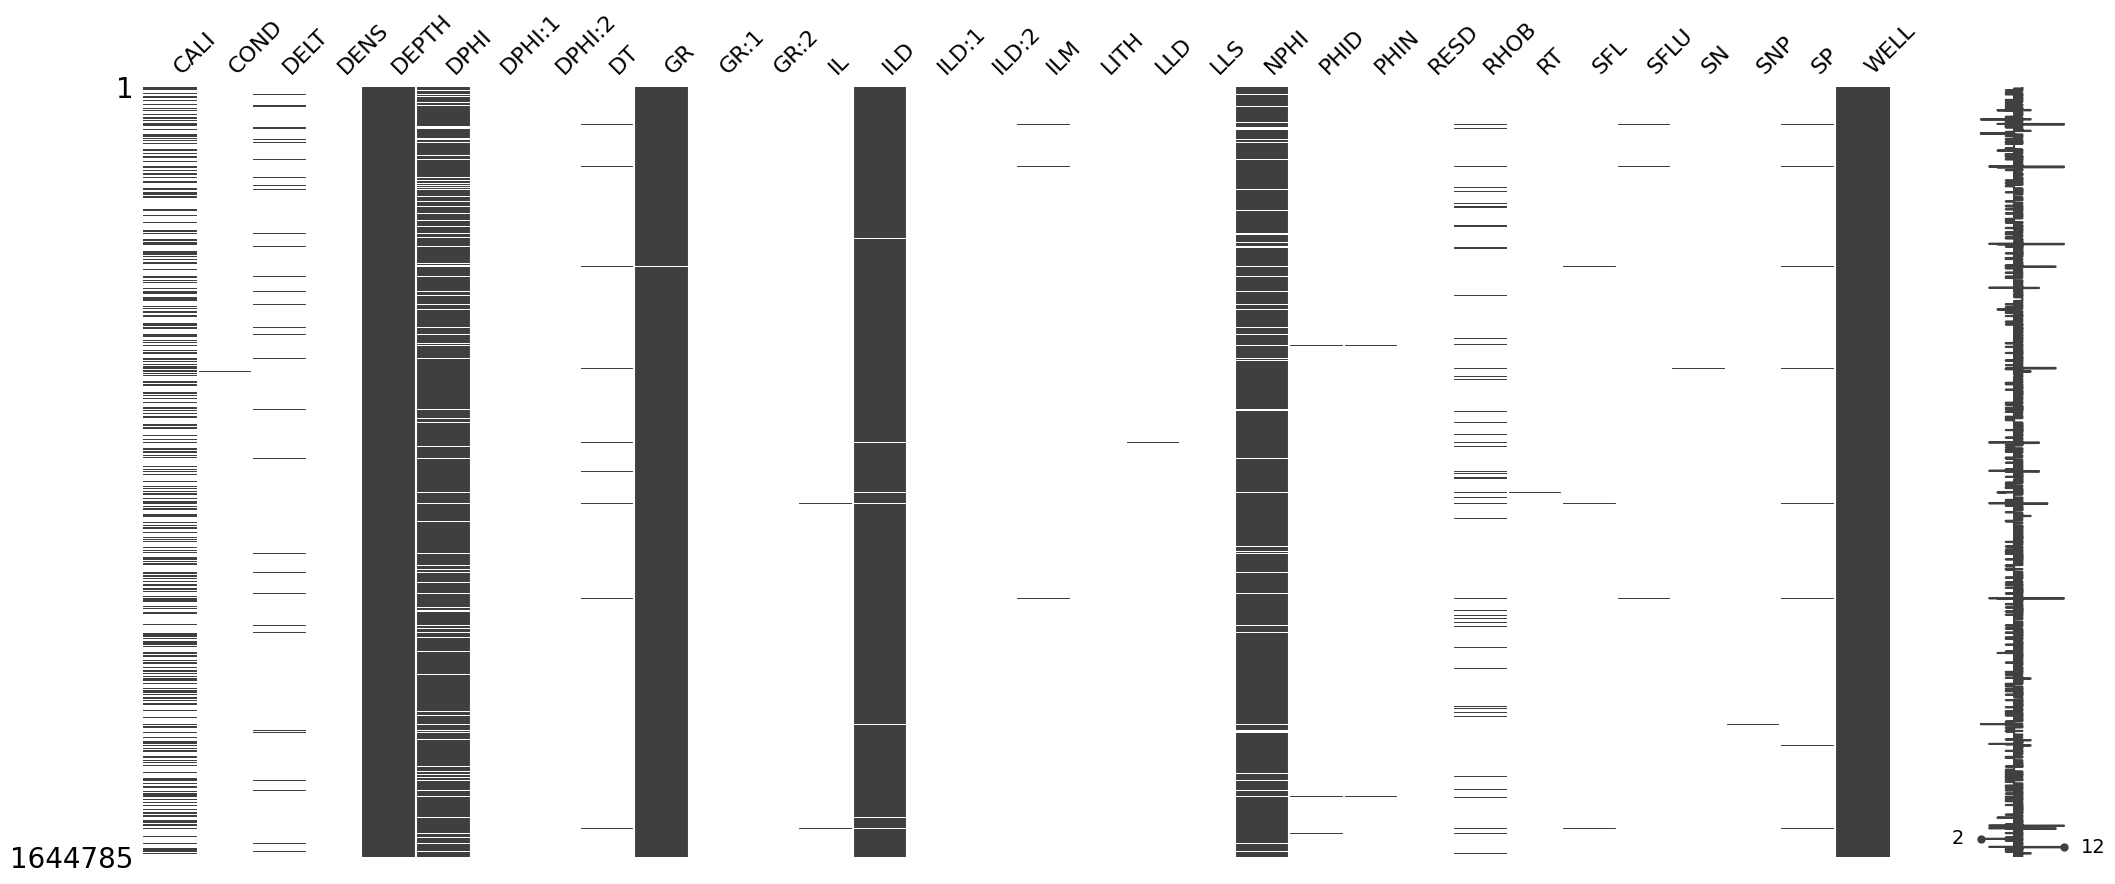

In [12]:
# Visualise the dataset to view missing points
msn.matrix(wells_single_df);

In [13]:
# Drops the missing point from selected well log
wells_single_df.dropna(subset=['DPHI', 'GR', 'ILD'], inplace=True)

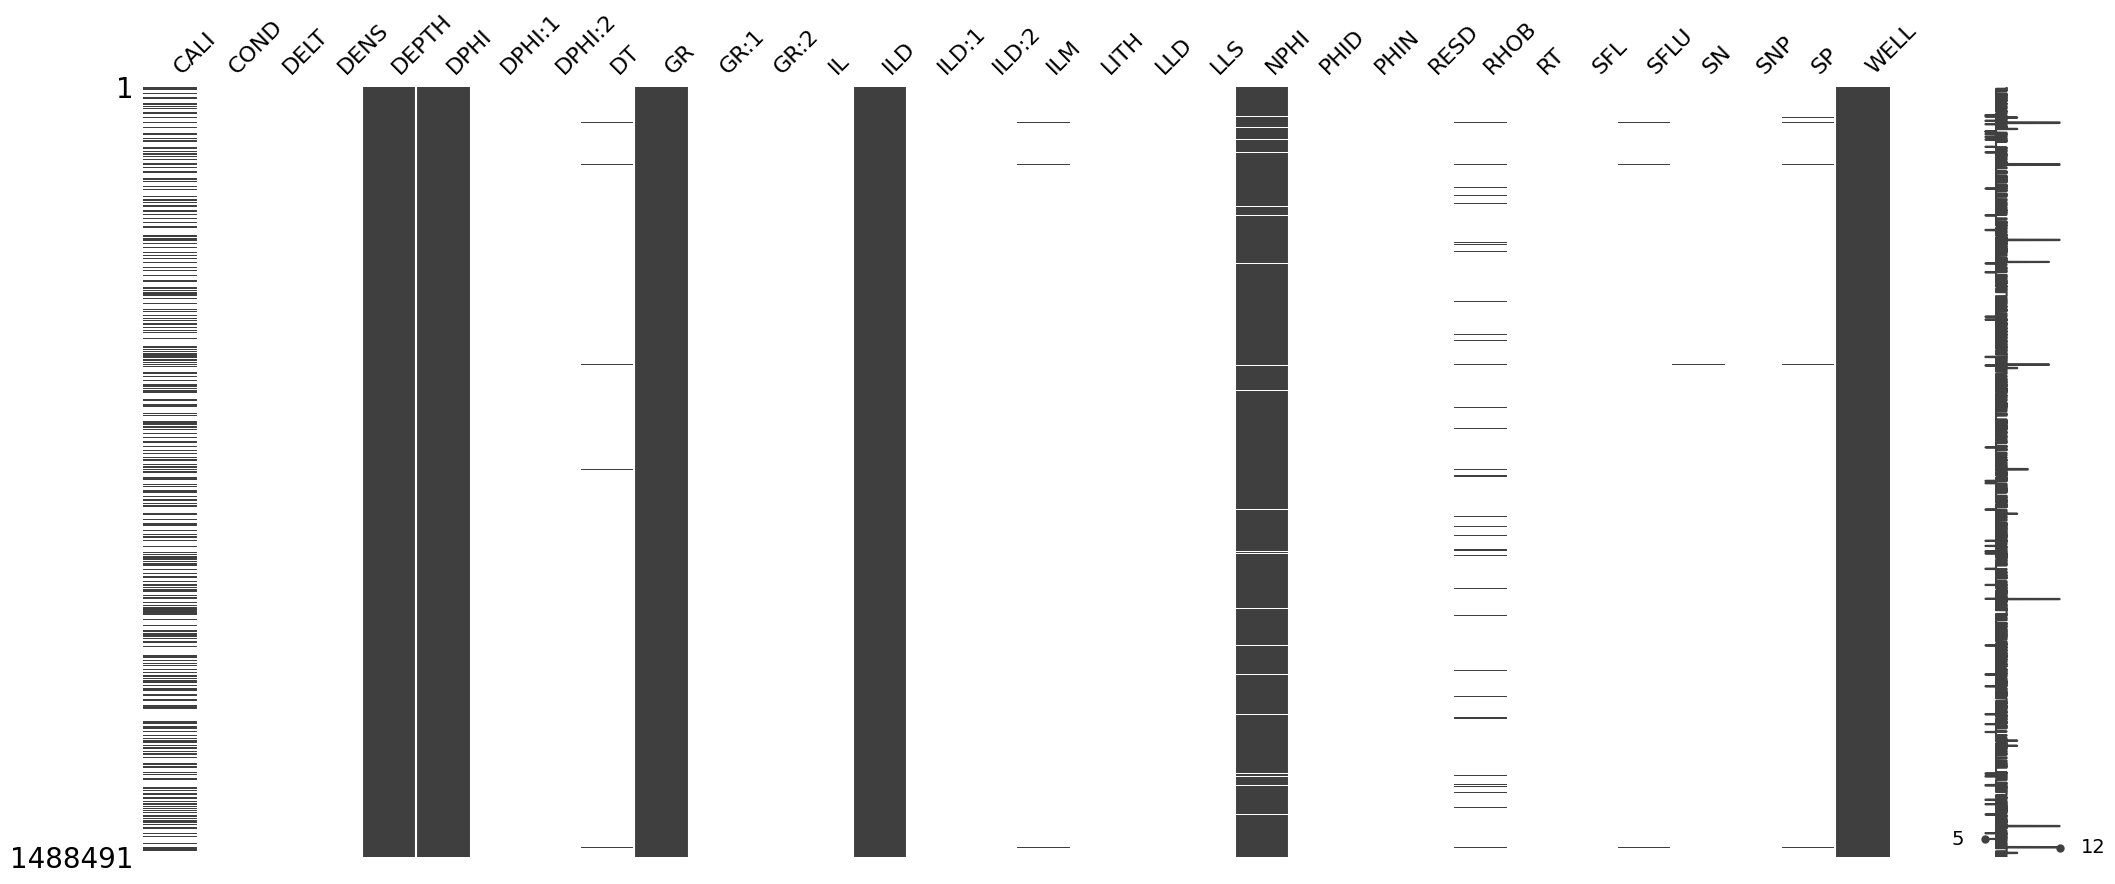

In [14]:
# Visualises the wells to ensure all misssing points have been dropped
msn.matrix(wells_single_df);

In [15]:
# Provides the total number of wells within the dataset
len(wells_single_df["WELL"].unique())

1350

In [16]:
# Initialize an empty list to store depth values
depth = []

# Initialize a counter variable to keep track of the depth index
counter = 0

# Iterate through the index of 'wells_single_df' DataFrame
for _ in wells_single_df.index:
    # Append the current depth value (counter + 1) to the 'depth' list
    depth.append(counter + 1)

    # Increment the counter by 1
    counter += 1

# Print the 'depth' list (optional)
# print(depth)

# Assign the 'depth' list to the 'Depth' column of 'wells_single_df' DataFrame
wells_single_df['Depth'] = depth

In [17]:
wells_single_df

,CALI,COND,DELT,DENS,DEPTH,DPHI,DPHI:1,DPHI:2,DT,GR,...,RESD,RHOB,RT,SFL,SFLU,SN,SNP,SP,WELL,Depth
0,213.326,NaN,NaN,NaN,182.88,0.244,NaN,NaN,NaN,88.909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4,1
1,216.975,NaN,NaN,NaN,183.13,0.239,NaN,NaN,NaN,89.593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4,2
2,228.405,NaN,NaN,NaN,183.38,0.250,NaN,NaN,NaN,90.952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4,3
3,218.356,NaN,NaN,NaN,183.63,0.268,NaN,NaN,NaN,91.267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4,4
4,220.659,NaN,NaN,NaN,183.88,0.256,NaN,NaN,NaN,89.684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-14-084-24W4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644780,NaN,NaN,NaN,NaN,229.00,0.233,NaN,NaN,NaN,98.777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-35-088-17W4,1488487
1644781,NaN,NaN,NaN,NaN,229.25,0.229,NaN,NaN,NaN,97.597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-35-088-17W4,1488488
1644782,NaN,NaN,NaN,NaN,229.50,0.219,NaN,NaN,NaN,97.032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-35-088-17W4,1488489
1644783,NaN,NaN,NaN,NaN,229.75,0.206,NaN,NaN,NaN,97.696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-35-088-17W4,1488490


In [18]:
# Creates a processed dataframe
wells = wells_single_df[['DPHI', 'GR', 'ILD', 'Depth', 'WELL', 'DEPTH']]

In [19]:
wells

,DPHI,GR,ILD,Depth,WELL,DEPTH
0,0.244,88.909,2.335,1,11-14-084-24W4,182.88
1,0.239,89.593,2.320,2,11-14-084-24W4,183.13
2,0.250,90.952,2.319,3,11-14-084-24W4,183.38
3,0.268,91.267,2.330,4,11-14-084-24W4,183.63
4,0.256,89.684,2.358,5,11-14-084-24W4,183.88
...,...,...,...,...,...,...
1644780,0.233,98.777,21.386,1488487,11-35-088-17W4,229.00
1644781,0.229,97.597,20.638,1488488,11-35-088-17W4,229.25
1644782,0.219,97.032,19.957,1488489,11-35-088-17W4,229.50
1644783,0.206,97.696,19.285,1488490,11-35-088-17W4,229.75


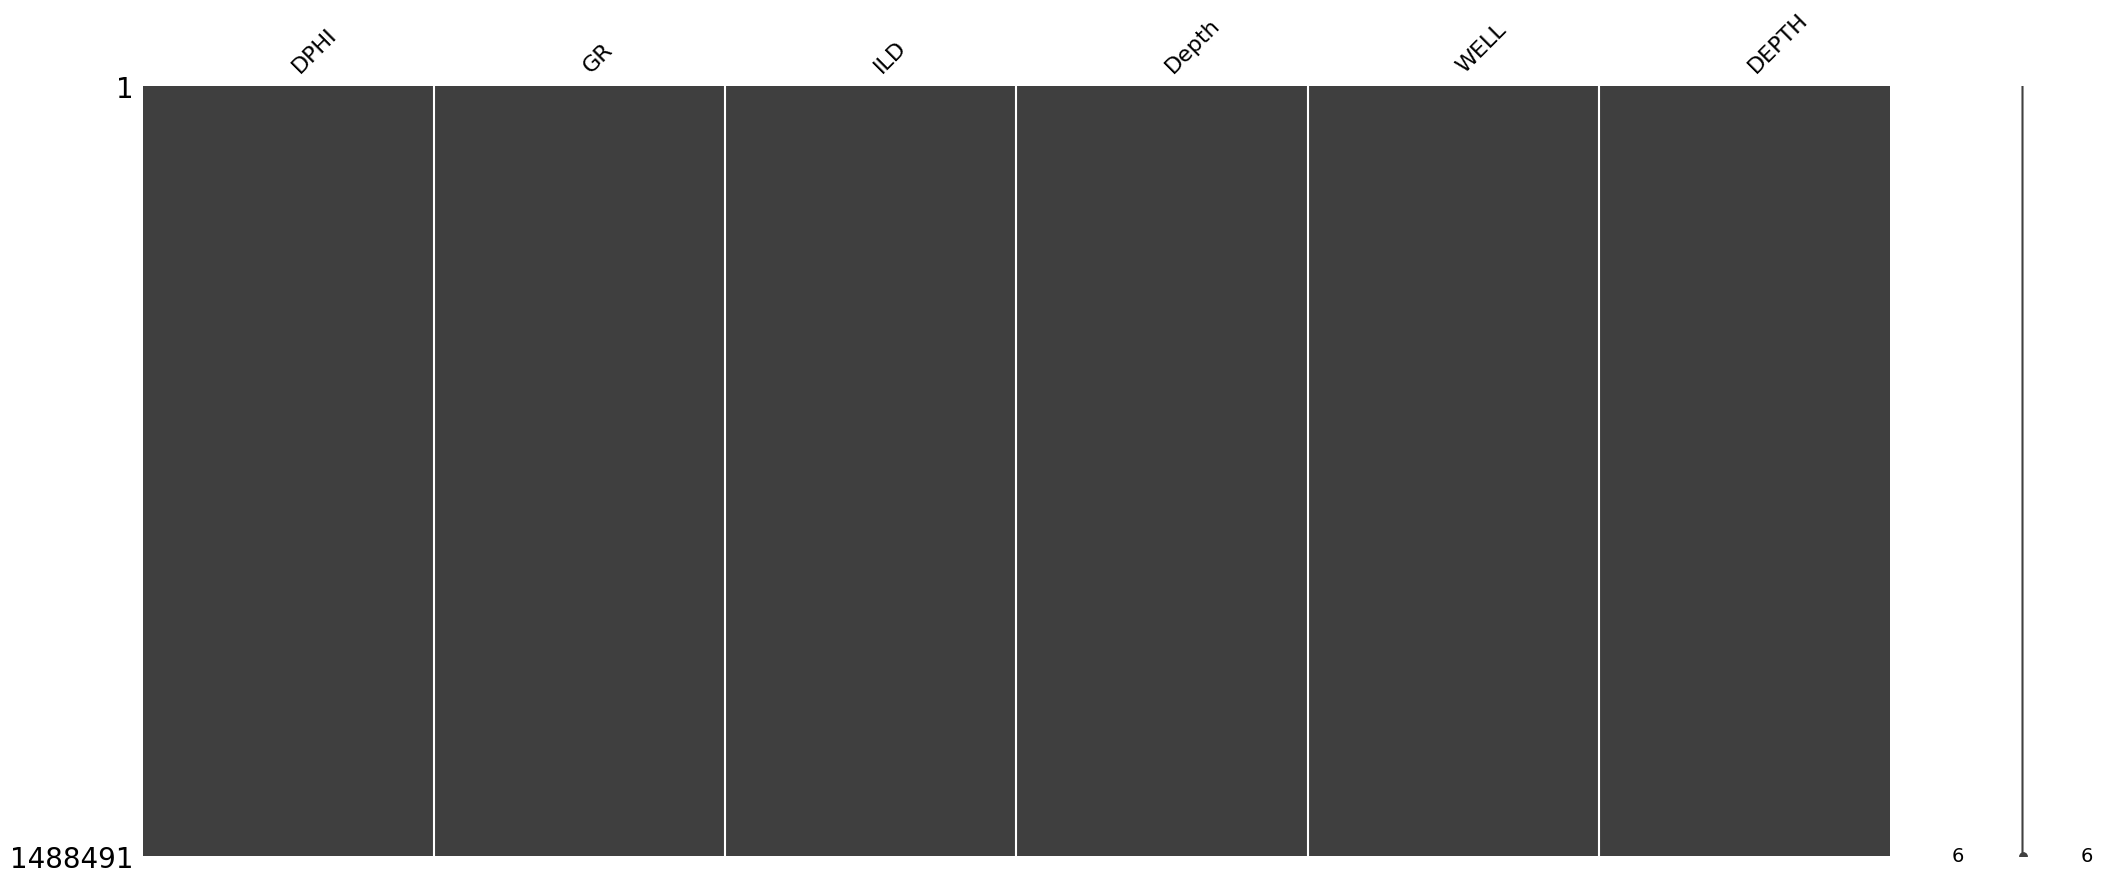

In [20]:
msn.matrix(wells);

In [21]:
# Checks for missing datapoints in each individual log
print(wells['DPHI'].isna().any(), 
      wells['GR'].isna().any(),
      wells['ILD'].isna().any())

False False False


### Training and Testing Data Split

In [22]:
# eliminates wells less than twice the length of max_encoder + max_prediction
category_counts = wells['WELL'].value_counts()
categories_to_keep = category_counts[category_counts >= 320].index
filtered_wells = wells[wells['WELL'].isin(categories_to_keep)]

# Group the DataFrame by the 'WELL' column, retrieves the last 160 for each well for testing
grouped = filtered_wells.groupby('WELL')
train_wells = grouped.apply(lambda x: x.iloc[:-160])#.reset_index(drop=True, inplace=True)
test_wells = grouped.apply(lambda x: x.iloc[-160:])#.reset_index(drop=True, inplace=True)

In [23]:
train_wells.reset_index(drop=True, inplace=True)
train_wells

,DPHI,GR,ILD,Depth,WELL,DEPTH
0,0.2833,93.6134,2.4396,85735,00/06-21-082-05W4/0,125.500
1,0.2913,94.1089,2.4566,85736,00/06-21-082-05W4/0,125.750
2,0.2946,93.9411,2.5343,85737,00/06-21-082-05W4/0,126.000
3,0.2873,92.4343,2.7256,85738,00/06-21-082-05W4/0,126.250
4,0.2827,90.4327,2.8801,85739,00/06-21-082-05W4/0,126.500
...,...,...,...,...,...,...
1268434,0.1910,84.4330,4.5410,583686,WINTERSHALL OIL OF CANADA,434.214
1268435,0.2060,85.3860,4.6060,583687,WINTERSHALL OIL OF CANADA,434.464
1268436,0.1970,87.1300,4.7400,583688,WINTERSHALL OIL OF CANADA,434.714
1268437,0.1780,88.8350,4.8850,583689,WINTERSHALL OIL OF CANADA,434.964


In [24]:
test_wells.reset_index(drop=True, inplace=True)
test_wells

,DPHI,GR,ILD,Depth,WELL,DEPTH
0,0.1489,29.4468,3.9302,86373,00/06-21-082-05W4/0,285.000
1,0.1317,33.3097,4.8609,86374,00/06-21-082-05W4/0,285.250
2,0.1082,35.1502,6.0640,86375,00/06-21-082-05W4/0,285.500
3,0.0844,33.0455,7.2842,86376,00/06-21-082-05W4/0,285.750
4,0.0655,27.6472,8.4358,86377,00/06-21-082-05W4/0,286.000
...,...,...,...,...,...,...
209435,0.1670,15.5750,5.0470,583846,WINTERSHALL OIL OF CANADA,474.214
209436,0.1510,15.4150,4.8720,583847,WINTERSHALL OIL OF CANADA,474.464
209437,0.1850,15.1990,4.7810,583848,WINTERSHALL OIL OF CANADA,474.714
209438,0.1690,14.9500,4.8040,583849,WINTERSHALL OIL OF CANADA,474.964


# Temporal Fusion Transformers

### Hyperparameters

In [25]:
# Initial hyperparameters
batch_size = 100
heads = 6
hidden_sizes = 480
learning_rate = 0.001
gradient_clipping = 0.1
max_prediction_length = 20
max_encoder_length = 7 * 20
max_epoch = 150
drop_out = 0.1
lstm_layers = 4

### TFT Dataloader

In [26]:
# Create a TimeSeriesDataSet for training data
training = TimeSeriesDataSet(
    train_wells,  # Training data
    time_idx="Depth",  # Time index column
    target="ILD",  # Target column
    group_ids=['WELL'],  # Group IDs if any
    min_encoder_length=max_encoder_length // 2,  # Minimum encoder length
    max_encoder_length=max_encoder_length,  # Maximum encoder length
    min_prediction_length=20,  # Minimum prediction length
    max_prediction_length=max_prediction_length,  # Maximum prediction length
    static_categoricals=['WELL'],  # Static categorical features if any
    time_varying_known_reals=['GR', 'DPHI', "DEPTH"],  # Time-varying known real features if any
    time_varying_unknown_reals=['ILD'],  # Time-varying unknown real features
    add_relative_time_idx=True,  # Add relative time index
    add_encoder_length=True,  # Add encoder length
    allow_missing_timesteps=True, # Accommodates potential missing timesteps
    categorical_encoders={'WELL': NaNLabelEncoder(add_nan=True)}
)

In [27]:
# Create a validation and testing dataset 
validation = TimeSeriesDataSet.from_dataset(training, train_wells, predict=True, stop_randomization=True)
testing = TimeSeriesDataSet.from_dataset(training, test_wells, predict=True, stop_randomization=True)

# Create a dataloader
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=32)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=32)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=32)

In [28]:
training.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,85735,86372,1,0,85735,638,0,159,160
1,85735,86372,1,1,85736,638,0,160,160
2,85735,86372,1,2,85737,638,0,161,160
3,85735,86372,1,3,85738,638,0,162,160
4,85735,86372,1,4,85739,638,0,163,160
...,...,...,...,...,...,...,...,...,...
1397505,583083,583690,1,1267831,583083,608,1308,1267985,155
1397506,583083,583690,1,1267831,583083,608,1308,1267986,156
1397507,583083,583690,1,1267831,583083,608,1308,1267987,157
1397508,583083,583690,1,1267831,583083,608,1308,1267988,158


In [29]:
validation.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
478,85735,86372,1,478,86213,638,0,637,160
1306,1452735,1453562,1,1306,1453403,828,1,1465,160
1867,830537,831097,1,1867,830938,561,2,2026,160
2328,557183,557643,1,2328,557484,461,3,2487,160
2789,955661,956121,1,2789,955962,461,4,2948,160
...,...,...,...,...,...,...,...,...,...
1265634,57368,57968,1,1265634,57809,601,1304,1265793,160
1266183,325662,326210,1,1266183,326051,549,1305,1266342,160
1266756,89429,90001,1,1266756,89842,573,1306,1266915,160
1267671,13172,14086,1,1267671,13927,915,1307,1267830,160


In [30]:
testing.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,86373,86532,1,0,86373,160,0,159,160
160,1453563,1453722,1,160,1453563,160,1,319,160
320,831098,831257,1,320,831098,160,2,479,160
480,557644,557803,1,480,557644,160,3,639,160
640,956122,956281,1,640,956122,160,4,799,160
...,...,...,...,...,...,...,...,...,...
208640,57969,58128,1,208640,57969,160,1304,208799,160
208800,326211,326370,1,208800,326211,160,1305,208959,160
208960,90002,90161,1,208960,90002,160,1306,209119,160
209120,14087,14246,1,209120,14087,160,1307,209279,160


### TFT Model

In [31]:
# Defines a custom class call back to retrieve loss values

class MetricsCallback(pl.Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_epoch_end(self, trainer, pl_module):
        metric = copy.deepcopy(trainer.callback_metrics)
        self.metrics.append(metric)

In [32]:
# Instantiates the class
metrics_callback = MetricsCallback()

In [33]:
warnings.filterwarnings("ignore")

# Define the Early Stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-5,
    patience=10,
    verbose=True,
    mode="min"
)

# Define the Learning Rate Monitor callback
lr_logger = LearningRateMonitor()

# Define the TensorBoard Logger
logger = TensorBoardLogger("lightning_logs")

# Define the Trainer configuration
trainer = pl.Trainer(
    max_epochs=max_epoch,
    accelerator='gpu',  # Use GPU acceleration
    devices=1,  # Number of GPUs to use
    enable_model_summary=True,  # Enable model summary
    gradient_clip_val=gradient_clipping,  # Gradient clipping value
    callbacks=[lr_logger, early_stop_callback, metrics_callback],  # Callbacks to use during training
    logger=logger  # Logger for tracking training progress
)

# Create the Temporal Fusion Transformer model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_sizes,
    attention_head_size=heads,
    dropout=drop_out,
    lstm_layers = lstm_layers,
    hidden_continuous_size=hidden_sizes,
    output_size=7,  # Number of quantiles (default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
    loss=QuantileLoss(),  # Loss function to use
    log_interval=10,  # Logging interval
    reduce_on_plateau_patience=4  # Patience for reducing learning rate on plateau
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Model Training

In [34]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: lightning_logs/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 116 K 
3  | prescalers                         | ModuleDict                      | 5.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 928 K 
5 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 6.427


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.328 >= min_delta = 1e-05. New best score: 5.099


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.855 >= min_delta = 1e-05. New best score: 4.244


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.529 >= min_delta = 1e-05. New best score: 3.715


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.320 >= min_delta = 1e-05. New best score: 3.395


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.657 >= min_delta = 1e-05. New best score: 2.738


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.278 >= min_delta = 1e-05. New best score: 2.460


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.268 >= min_delta = 1e-05. New best score: 2.192


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.376 >= min_delta = 1e-05. New best score: 1.815


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.162 >= min_delta = 1e-05. New best score: 1.653


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.150 >= min_delta = 1e-05. New best score: 1.503


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.081 >= min_delta = 1e-05. New best score: 1.422


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.189 >= min_delta = 1e-05. New best score: 1.233


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 1e-05. New best score: 1.195


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.196 >= min_delta = 1e-05. New best score: 1.000


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 1e-05. New best score: 0.931


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.081 >= min_delta = 1e-05. New best score: 0.850


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 1e-05. New best score: 0.809


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 1e-05. New best score: 0.756


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.747


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 1e-05. New best score: 0.695


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.686


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 1e-05. New best score: 0.674


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.050 >= min_delta = 1e-05. New best score: 0.623


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 1e-05. New best score: 0.588


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 1e-05. New best score: 0.540


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 1e-05. New best score: 0.500


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.498


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 1e-05. New best score: 0.464


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 1e-05. New best score: 0.418


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.075 >= min_delta = 1e-05. New best score: 0.343


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 1e-05. New best score: 0.324


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 1e-05. New best score: 0.302


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 1e-05. New best score: 0.291


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 1e-05. New best score: 0.272


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 1e-05. New best score: 0.250


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.241


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.237


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 1e-05. New best score: 0.221


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 1e-05. New best score: 0.204


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.199


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.198


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.194


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.189


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.188


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.186


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.186


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.184


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.184. Signaling Trainer to stop.


In [35]:
train_loss = []
validation_loss = []
for index in range(len(metrics_callback.metrics)):
  try:
    train_loss.append(float(metrics_callback.metrics[index]['train_loss']))
    validation_loss.append(float(metrics_callback.metrics[index]['val_loss']))

  except:
    pass

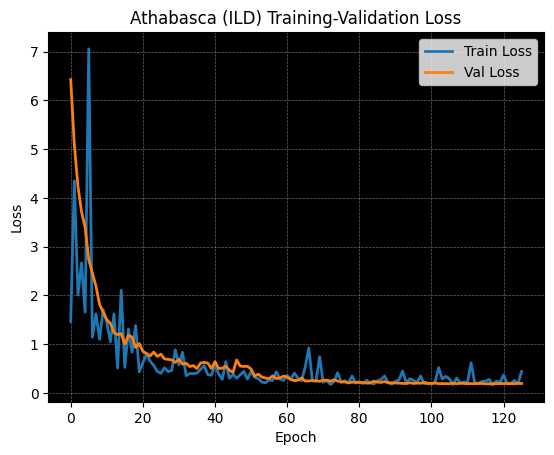

In [40]:
# Create a new figure with a dark background
fig, ax = plt.subplots()
fig.set_facecolor('white')
ax.set_facecolor('black')

plt.plot(train_loss, linewidth=2, label= "Train Loss");
plt.plot(validation_loss, linewidth=2, label = "Val Loss")

# Add labels to x-axis and y-axis (customize as needed)
ax.set_xlabel("Epoch", color='black')
ax.set_ylabel("Loss", color='black')

# Customize other plot properties (title, grid, etc.)
ax.set_title("Athabasca (ILD) Training-Validation Loss", color='black', fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

# Customize tick labels and colors
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

plt.legend(loc="upper right")

plt.savefig("/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Images/Athabasca/ILD/Athabasca ILD Loss.pdf", format="pdf", bbox_inches="tight") # Saves the figure


# Show the plot
plt.show()

In [41]:
warnings.filterwarnings("ignore")
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path) #loads the model

lightning_logs/lightning_logs/version_0/checkpoints/epoch=125-step=1553958.ckpt


In [42]:
#zip and download the model
!zip  -r '/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Models/Athabasca_Welllog_[ILD].zip' lightning_logs/lightning_logs/version_0/*

  adding: lightning_logs/lightning_logs/version_0/1553958/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/1553958/WELL/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/1553958/WELL/tensors.tsv (deflated 54%)
  adding: lightning_logs/lightning_logs/version_0/1553958/WELL/metadata.tsv (deflated 71%)
  adding: lightning_logs/lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/checkpoints/epoch=125-step=1553958.ckpt (deflated 8%)
  adding: lightning_logs/lightning_logs/version_0/events.out.tfevents.1701584611.76-2223-03.2660659.0 (deflated 20%)
  adding: lightning_logs/lightning_logs/version_0/hparams.yaml (deflated 79%)
  adding: lightning_logs/lightning_logs/version_0/projector_config.pbtxt (deflated 36%)


In [34]:
#load our saved model again
!unzip -o '/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Models/Athabasca_Welllog_[ILD].zip'
best_model_path='lightning_logs/lightning_logs/version_0/checkpoints/epoch=125-step=1553958.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Archive:  /home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Models/Athabasca_Welllog_[ILD].zip
  inflating: lightning_logs/lightning_logs/version_0/1553958/WELL/tensors.tsv  
  inflating: lightning_logs/lightning_logs/version_0/1553958/WELL/metadata.tsv  
  inflating: lightning_logs/lightning_logs/version_0/checkpoints/epoch=125-step=1553958.ckpt  
  inflating: lightning_logs/lightning_logs/version_0/events.out.tfevents.1701584611.76-2223-03.2660659.0  
  inflating: lightning_logs/lightning_logs/version_0/hparams.yaml  
  inflating: lightning_logs/lightning_logs/version_0/projector_config.pbtxt  


### Validation Evaluation

In [43]:
warnings.filterwarnings("ignore")

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader,trainer_kwargs=dict(accelerator="cpu"))

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

0.3256992697715759
tensor([0.0296, 0.4216, 0.3386,  ..., 0.0823, 0.0863, 0.0830])


In [44]:
warnings.filterwarnings("ignore")
trainer.test(best_tft,val_dataloader);

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MAE          │    0.32568538188934326    │
│         test_MAPE         │   0.016764335334300995    │
│         test_RMSE         │    1.4918819665908813     │
│        test_SMAPE         │    0.01677316054701805    │
│         test_loss         │    0.19109198451042175    │
└───────────────────────────┴───────────────────────────┘

In [49]:
def pred_plot_df(well_name, well=train_wells, pred_data=validation, tft_model=best_tft, accelerator="cpu"):

    # Creates a dataframe containing just the selected well
    well_df  = well[well["WELL"] == well_name]

    # Creates the new index for the observed values and values to be predicted: Uses 160 because the encoder length is set to 140, plus the max_prediction of 20 totals 160
    values = well_df["DEPTH"].tolist()
    observed_idx = values[-160:]
    pred_idx = values[-20:]

    # Prepares the observed data for plotting
    new_well_df = well_df.iloc[-160:].copy()
    new_well_df["Depth index"] = observed_idx
    new_well_df.set_index("Depth index", inplace=True)

    # Conducts the prediction 
    single_pred =best_tft.predict(pred_data.filter(lambda x: (x.WELL == well_name)),
                                  mode="raw",
                                  trainer_kwargs=dict(accelerator=accelerator), 
                                  return_x=True, 
                                  return_y=True)

    # Retrieves the predicted output and converts to dataframe for plotting 
    pred_data = single_pred.output.prediction[:, :, 4][0]  # [:, :, 4] 4 was used because we're interested in the 50th quantile
    pred_df = pd.DataFrame(pred_data.numpy())
    pred_df["pred_index"] = pred_idx
    pred_df.set_index("pred_index", inplace=True)
    pred_df

    return new_well_df, pred_df, pred_idx

In [50]:
# Gets the number of unique wells
train_wells_len = len(train_wells['WELL'].unique())
print(train_wells_len)

# Retrieves a list of the well names
well_names_list = train_wells['WELL'].unique()
well_names_list[12]

1309


'01-28-093-11W4'

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightning")
for well_name in well_names_list:
    X, Y,_ = pred_plot_df(well_name)
    
    # Create a new figure for each plot
    fig, ax = plt.subplots()
    
    # Plot the data on the axes
    ax.plot(X['ILD'], label="Observed")
    ax.plot(Y, label="Pred")

    fig.set_facecolor('white')
    
    # Set the background color of the figure
    ax.set_facecolor('black')  # 
    
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)
    
    # Customize the plot title and legend
    ax.set_title(f"{well_name}")
    ax.legend()

    # Add labels to x-axis and y-axis
    ax.set_xlabel("Depth")  
    ax.set_ylabel("ILD Value")  

    # Define the directory where you want to save the files
    save_directory = "/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Images/Athabasca/ILD/Validation/"

    # Create the directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    
    s_well_name = well_name.replace('/', '_')

    # Generate the file name based on the well_name
    file_name = os.path.join(save_directory, f"validation-{s_well_name}.pdf")

    # Save the figure with the unique file name
    plt.savefig(file_name, format="pdf", bbox_inches="tight")

    # Show the plot
    plt.show()
warnings.resetwarnings()

In [48]:
warnings.filterwarnings("ignore")
# Compares the prediction against the actual for the entire validation dataset
predictions = best_tft.predict(val_dataloader, return_x=True,trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
#best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

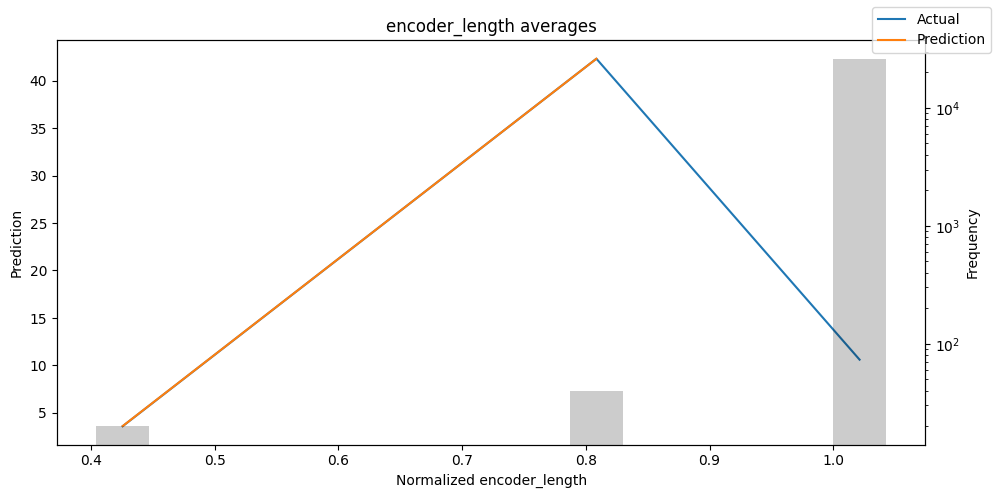

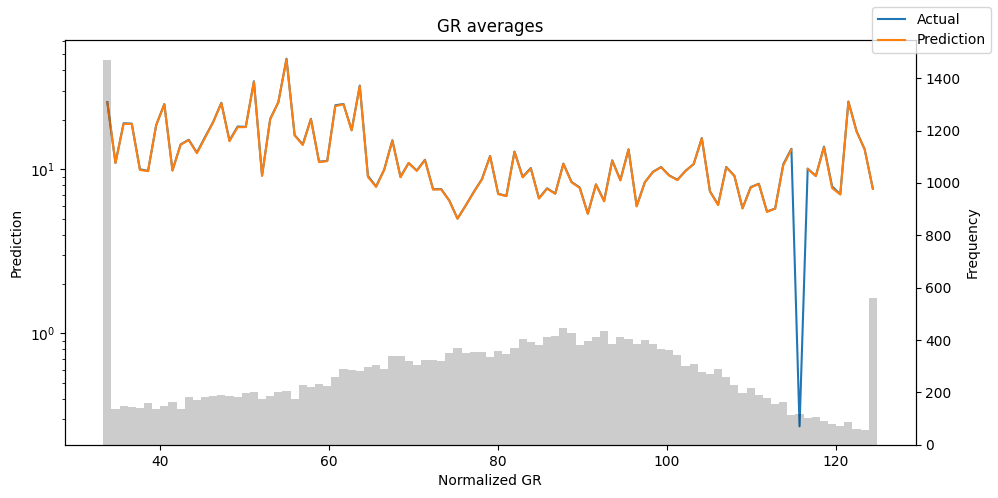

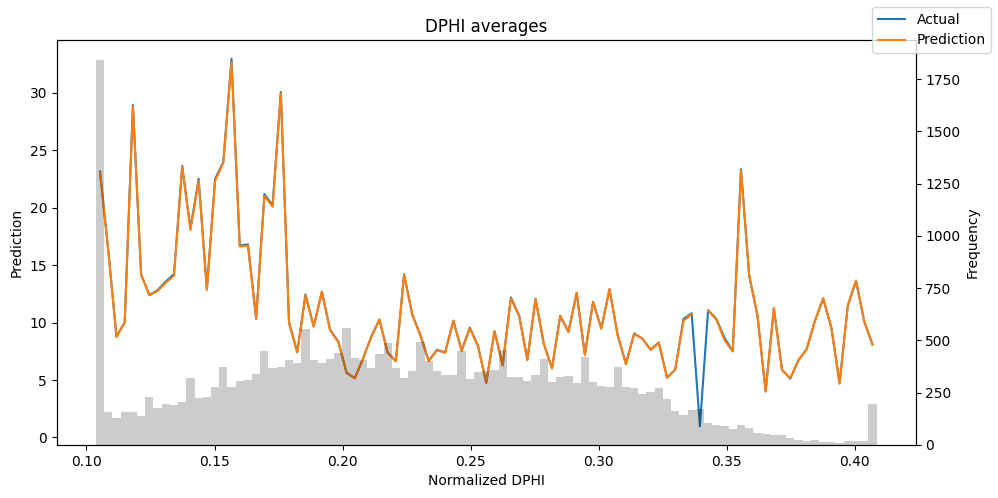

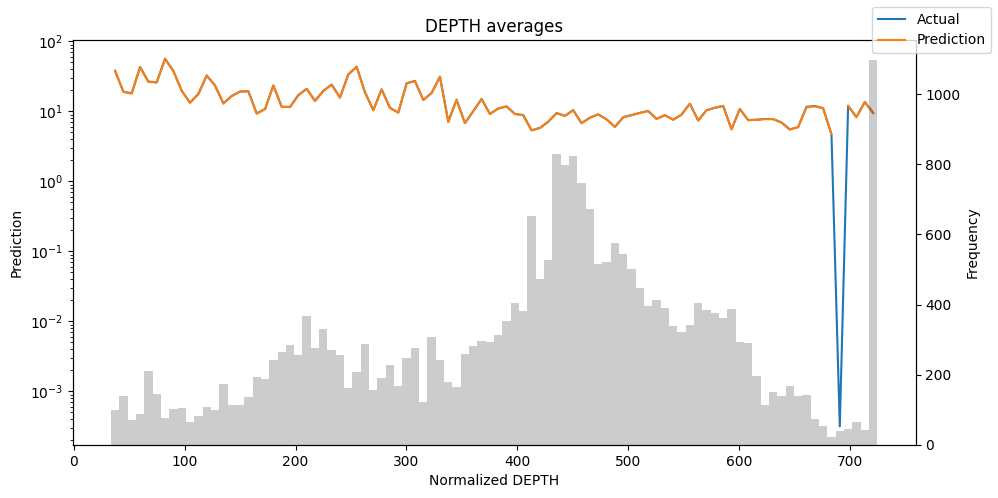

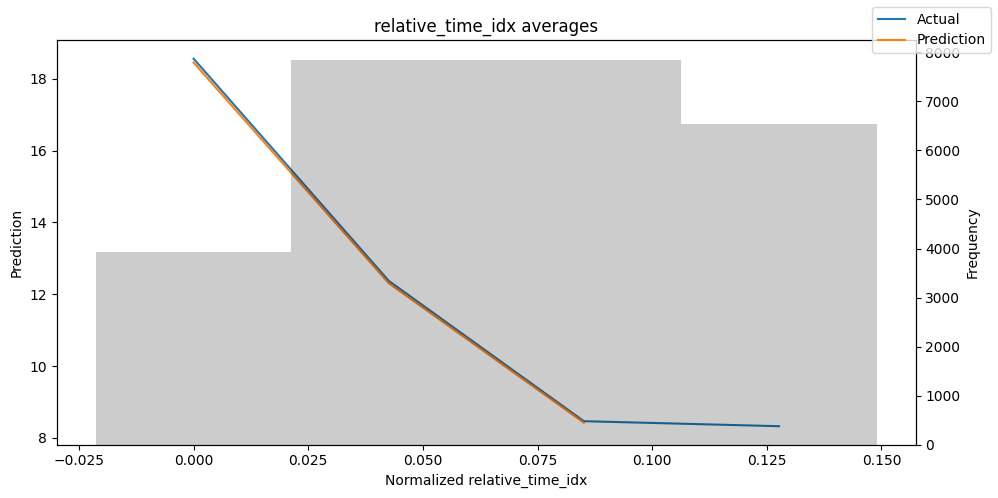

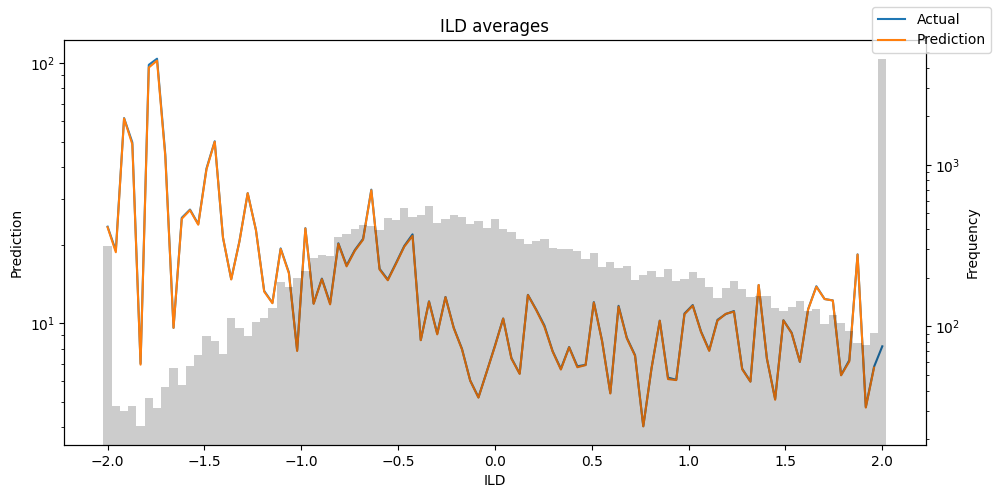

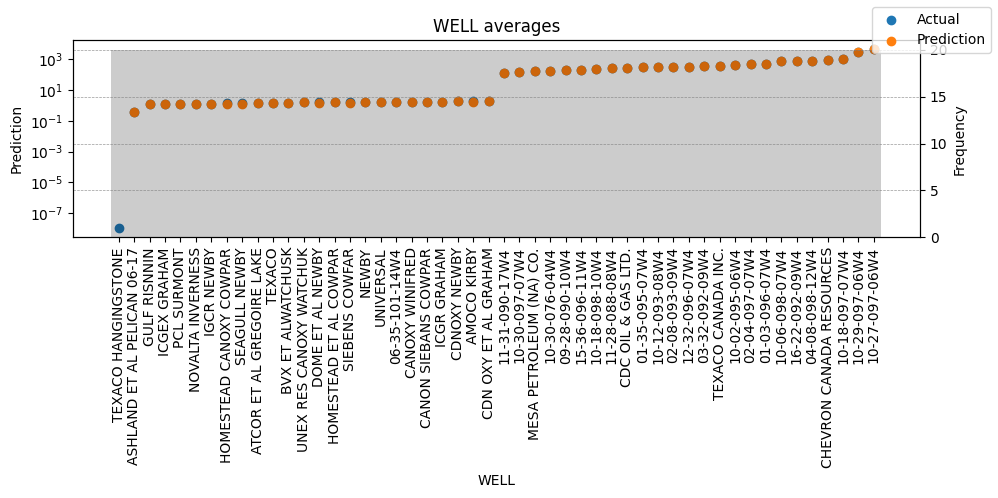

In [49]:
# Plot the data using the method provided by best_tft
fig = best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

# Show the plot
plt.show()


### Testing Evaluation

In [50]:
warnings.filterwarnings("ignore")

test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
test_predictions = best_tft.predict(test_dataloader,trainer_kwargs=dict(accelerator="cpu"))

#average p50 loss overall
print((test_actuals - test_predictions).abs().mean().item())
#average p50 loss per time series
print((test_actuals - test_predictions).abs().mean(axis=1))

26.186038970947266
tensor([  3.6447,   2.1737, 319.1521,  ...,   3.9675,   3.8932,   1.0498])


In [51]:
# Gets the number of unique wells
test_wells_len = len(train_wells['WELL'].unique())
print(test_wells_len)

# Retrieves a list of the well names
test_well_names_list = test_wells['WELL'].unique()
test_well_names_list[12]

1309


'01-28-093-11W4'

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightning")
for well_name in well_names_list:
    X, Y,_ = pred_plot_df(well_name,well=test_wells, pred_data=testing)
    
    # Create a new figure for each plot
    fig, ax = plt.subplots()
    
    # Plot the data on the axes
    ax.plot(X['ILD'], label="Observed")
    ax.plot(Y, label="Pred")

    fig.set_facecolor('white')
    
    # Set the background color of the figure
    ax.set_facecolor('black')  # 
    
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)
    
    # Customize the plot title and legend
    ax.set_title(f"{well_name}")
    ax.legend()

    # Add labels to x-axis and y-axis
    ax.set_xlabel("Depth")  
    ax.set_ylabel("ILD Value")  

    # Define the directory where you want to save the files
    save_directory = "/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Images/Athabasca/ILD/Testing/"

    # Create the directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    
    s_well_name = well_name.replace('/', '_')

    # Generate the file name based on the well_name
    file_name = os.path.join(save_directory, f"testing-{s_well_name}.pdf")

    # Save the figure with the unique file name
    plt.savefig(file_name, format="pdf", bbox_inches="tight")

    # Show the plot
    plt.show()
warnings.resetwarnings()

In [ ]:
warnings.filterwarnings("ignore")
trainer.test(best_tft,test_dataloader);

In [ ]:
warnings.filterwarnings("ignore")
# Compares the prediction against the actual for the entire validation dataset
predictions = best_tft.predict(val_dataloader, return_x=True,trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
#best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
# Plot the data using the method provided by best_tft
fig = best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

# Show the plot
plt.show()


# Other Models

### Support Vector Machine

In [ ]:
# SVM Optimum hyperparameter search


# Splits training and testing dataset
wells_F = train_wells[['GR', 'DPHI']]
wells_T = train_wells[["ILD"]]

# Preprocessing: Scaling the data (important for SVMs)
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(wells_F)
y_train_scaled = scaler_Y.fit_transform(wells_T).ravel() # convert to 1D array

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'degree': [2, 3, 4, 5]  # only used by the 'poly' kernel
}

grid_search = GridSearchCV(SVR(), param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)
best_svr = grid_search.best_estimator_

In [ ]:
best_svr

In [35]:
def SVM(well_name, train_well=train_wells, test_well=test_wells, kernel="sigmoid", C=100, Gamma=0.01, degree=2):
    
    # Creates a dataframe containing just the selected well
    train_well_df = train_well[train_well["WELL"] == well_name]
    test_well_df = test_well[test_well["WELL"] == well_name]

    # Splitting the well data into training and testing datasets
    train_wells_F = train_well_df[['GR', 'DPHI']]
    train_wells_T = train_well_df[["ILD"]]
    test_wells_F = test_well_df[['GR', 'DPHI']]
    test_wells_T = test_well_df[["ILD"]]

    # Scaling the data
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(train_wells_F)
    X_test_scaled = scaler_X.transform(test_wells_F)

    y_train_scaled = scaler_Y.fit_transform(train_wells_T).ravel()
    y_test_scaled = scaler_Y.transform(test_wells_T).ravel()

    # Training the SVM Regressor
    svr = SVR(kernel=kernel, C=C, gamma=Gamma, degree=degree)
    svr.fit(X_train_scaled, y_train_scaled)

    # Making Predictions
    y_pred_scaled = svr.predict(X_test_scaled)
    y_pred = scaler_Y.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # Evaluating the Model
    mse = mean_squared_error(test_wells_T, y_pred)

    # Return the last twenty predicted ILD values
    y = y_pred[-20:]

    return y, mse

### Random Forest

In [36]:
def RF(well_name, train_well=train_wells, test_well=test_wells):
    
    # Creates a dataframe containing just the selected well
    train_well_df = train_well[train_well["WELL"] == well_name]
    test_well_df = test_well[test_well["WELL"] == well_name]

    # Splitting the well data into training and testing datasets
    train_wells_F = train_well_df[['GR', 'DPHI']]
    train_wells_T = train_well_df[["ILD"]]
    test_wells_F = test_well_df[['GR', 'DPHI']]
    test_wells_T = test_well_df[["ILD"]]

    # Preprocessing: Scaling the data 
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(train_wells_F)
    X_test_scaled = scaler_X.transform(test_wells_F)

    y_train_scaled = scaler_Y.fit_transform(train_wells_T).ravel() # ravel to convert to 1D array
    y_test_scaled = scaler_Y.transform(test_wells_T).ravel()
    
    feature_importance = []

    # Create and train the random forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train_scaled)
    
    # Making Predictions
    y_pred_scaled = rf.predict(X_test_scaled)
    y_pred = scaler_Y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    # Calculate the mean squared error for the predictions
    mse = mean_squared_error(test_wells_T, y_pred)
    #print(f"Mean Squared Error: {mse}")
    
    # check feature importances
    importances = rf.feature_importances_
    for feature, importance in zip(wells.columns, importances):
        feature_importance.append(f"{feature}: {importance}")

    # Return the last twenty predicted ILD values
    y = y_pred[-20:]
    
    return y, mse, feature_importance

### XG BOOST

In [ ]:
# Optimum Hyperparameter grid search

# Splits training and testing dataset
wells_F = train_wells[['GR', 'DPHI']]
wells_T = train_wells[["ILD"]]

# Preprocessing: Scaling the data (important for SVMs)
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(wells_F)
y_train_scaled = scaler_Y.fit_transform(wells_T).ravel() # ravel to convert to 1D array

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
# Define the hyperparameters and their search space
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
}

# Define the scoring metric for optimization
scoring = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=scoring, cv=3, verbose=2, n_jobs=-1)

# Fit the GridSearchCV to your data
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

In [38]:
def XGB(well_name, train_well=train_wells, test_well=test_wells):

        # Creates a dataframe containing just the selected well
    train_well_df = train_well[train_well["WELL"] == well_name]
    test_well_df = test_well[test_well["WELL"] == well_name]

    # Splitting the well data into training and testing datasets
    train_wells_F = train_well_df[['GR', 'DPHI']]
    train_wells_T = train_well_df[["ILD"]]
    test_wells_F = test_well_df[['GR', 'DPHI']]
    test_wells_T = test_well_df[["ILD"]]
    
    # Preprocessing: Scaling the data (important for SVMs)
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(train_wells_F)
    X_test_scaled = scaler_X.transform(test_wells_F)

    y_train_scaled = scaler_Y.fit_transform(train_wells_T).ravel() # ravel to convert to 1D array
    y_test_scaled = scaler_Y.transform(test_wells_T).ravel()
    
    # Suppress future warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Convert data into DMatrix format for XGBoost
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled)

    # Define parameters for the XGBoost model
    param = {
    'max_depth': 4,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'reg:squarederror',  # error function for regression
    'eval_metric': 'rmse',  # evaluation metric for regression
    }
    
    # Specify validation set for performance monitoring
    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    
    # Train the model
    num_round = 100  # number of boosting rounds
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
    
    # Predict the test set
    y_pred_scaled = bst.predict(dtest)
    y_pred = scaler_Y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    # Calculate RMSE
    rmse = mean_squared_error(test_wells_T, y_pred, squared=False)

    # Return the last twenty predicted ILD values
    y = y_pred[-20:]
    
    return y, rmse

### Conv.BiLSTM

In [42]:
def Conv_BiLSTM(well_name, train_well=train_wells, test_well=test_wells):
    seed = 42  
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    # Create DataFrames containing just the selected well from training and testing datasets
    train_well_df = train_well[train_well["WELL"] == well_name]
    test_well_df = test_well[test_well["WELL"] == well_name]

    # Extracting features and target from DataFrames as numpy arrays
    train_wells_F = np.array(train_well_df[['GR', 'DPHI']], dtype=np.float32)
    train_wells_T = np.array(train_well_df[["ILD"]], dtype=np.float32)
    test_wells_F = np.array(test_well_df[['GR', 'DPHI']], dtype=np.float32)
    test_wells_T = np.array(test_well_df[["ILD"]], dtype=np.float32)

    class LSTM(nn.Module):
        def __init__(self, in_size=2, n_hidden=60):
            super(LSTM, self).__init__()
            self.hidden = n_hidden
            self.conv1 = nn.Conv1d(in_channels=in_size, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.relu = nn.ReLU()
            self.lstm = nn.LSTM(input_size=16, hidden_size=self.hidden, num_layers=4, bidirectional=True)
            self.fc = nn.Linear(self.hidden * 2, 1)  # times 2 because of bidirectional
    
        def forward(self, x):
            x = self.conv1(x.transpose(1, 2))
            x = self.relu(x).transpose(1, 2)
            lstm_out, _ = self.lstm(x)
            return self.fc(lstm_out).squeeze(1)
    
    # Convert data to PyTorch tensors
    wells_Features_tensor = torch.tensor(train_wells_F, dtype=torch.float32)
    wells_Target_tensor = torch.tensor(train_wells_T, dtype=torch.float32)
    
    # Create DataLoader for batching
    batch_size = 100
    train_dataset = TensorDataset(wells_Features_tensor, wells_Target_tensor)  
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTM().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    n_epochs = 500
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.unsqueeze(1)  # This ensures the shape (sequence_length, batch_size, input_size)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)  # Store the average loss for this epoch

    # Convert test data to PyTorch tensors
    test_Features_tensor = torch.tensor(test_wells_F, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        predictions = model(test_Features_tensor)
    
    # Convert predictions to numpy
    y_pred = predictions.cpu().numpy()
    
    # Calculate RMSE
    rmse = mean_squared_error(test_wells_T, y_pred, squared=False)

    # Return the last twenty predicted ILD values
    y = y_pred[-20:]

    return y, rmse, losses


In [43]:
_,_,L =Conv_BiLSTM("03-25-096-16W4")

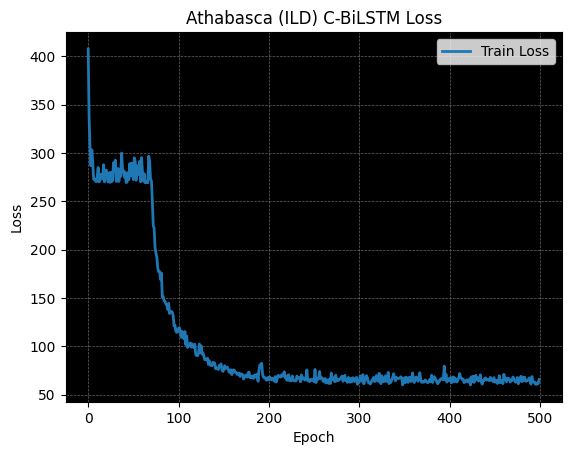

In [44]:
# Create a new figure with a dark background
fig, ax = plt.subplots()
fig.set_facecolor('white')
ax.set_facecolor('black')

plt.plot(L, linewidth=2, label= "Train Loss");

# Add labels to x-axis and y-axis (customize as needed)
ax.set_xlabel("Epoch", color='black')
ax.set_ylabel("Loss", color='black')

# Customize other plot properties (title, grid, etc.)
ax.set_title("Athabasca (ILD) C-BiLSTM Loss", color='black', fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

# Customize tick labels and colors
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

plt.legend(loc="upper right")

plt.savefig("/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Images/Athabasca/ILD/C-BiLSTM Loss.pdf", format="pdf", bbox_inches="tight") # Saves the figure


# Show the plot
plt.show()

### Combined Test Outcomes

In [45]:
# Helper function to correct the index of predictions
def fix_index(data, index):
    data_df = pd.DataFrame(data)
    index = index[-20:]
    data_df["pred_index"]=index
    data_df.set_index("pred_index", inplace=True)

    return data_df

In [ ]:
y_CBLSTM, _, loss = Conv_BiLSTM(well_name)


In [ ]:
len(y_CBLSTM)

In [ ]:
y_CBLSTM_df = fix_index(y_CBLSTM, pred_index)

In [ ]:
y_SVM_df

In [ ]:
random_num = random.randint(0,len(well_names_list))
well_name = well_names_list[random]
well_name

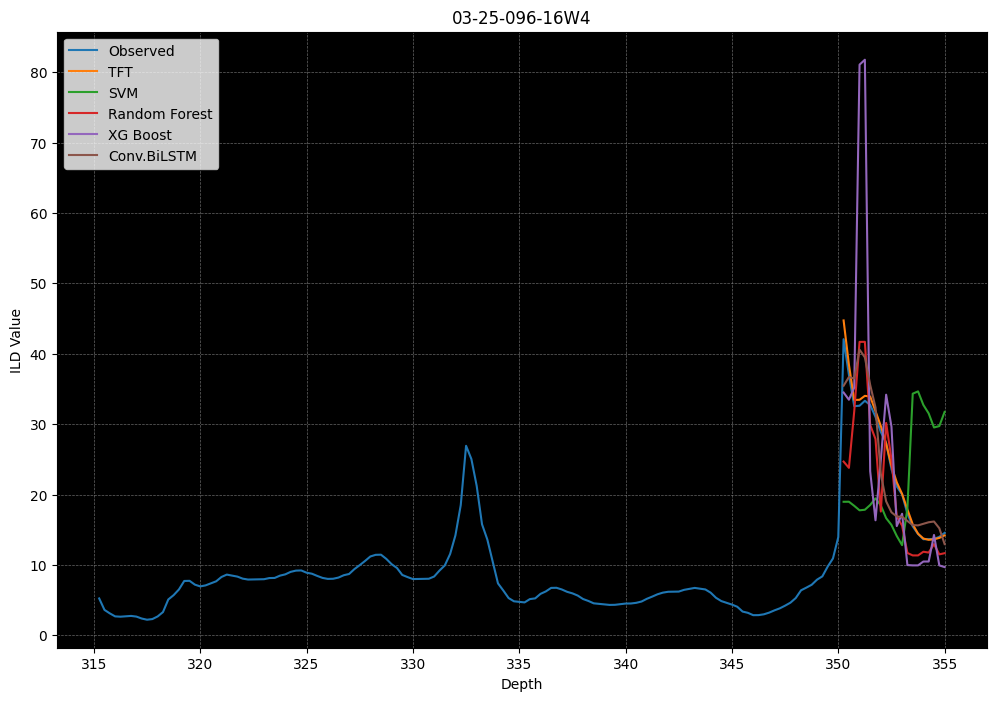

In [51]:
# Loop over each well_name
for well_name in ["03-25-096-16W4"]: #well_names_list:
    # Ignore UserWarnings during plotting
    warnings.filterwarnings("ignore", category=UserWarning, module="lightning")

    # TFT and true prediction depth index
    X, Y, pred_index = pred_plot_df(well_name)

    # SVM
    y_SVM, _ = SVM(well_name)
    y_SVM_df = fix_index(y_SVM, pred_index)

    # Random Forest
    y_rand_F, _, _ = RF(well_name)
    y_rand_F_df = fix_index(y_rand_F, pred_index)

    # XG Boost
    y_xgb, _ = XGB(well_name)
    y_xgb_df = fix_index(y_xgb, pred_index)

    # Conv.BiLSTM
    y_CBLSTM, _, loss = Conv_BiLSTM(well_name)
    y_CBLSTM_df = fix_index(y_CBLSTM, pred_index)

    # Create a new figure for each plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the data on the axes
    ax.plot(X['ILD'][-140:], label="Observed")
    ax.plot(Y, label="TFT")
    ax.plot(y_SVM_df, label="SVM")
    ax.plot(y_rand_F_df, label="Random Forest")
    ax.plot(y_xgb_df, label="XG Boost")
    ax.plot(y_CBLSTM_df, label="Conv.BiLSTM")
    
    fig.set_facecolor('white')
    
    # Set the background color of the figure
    ax.set_facecolor('black')
    
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)
    
    # Customize the plot title and legend
    ax.set_title(f"{well_name}")
    ax.legend()
    
    # Add labels to x-axis and y-axis
    ax.set_xlabel("Depth")
    ax.set_ylabel("ILD Value")
    
    # Define the directory where you want to save the files
    save_directory = "/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Images/Athabasca/ILD/Combined/"
    
    # Create the directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    
    # Save the figure with a unique file name
    s_well_name = well_name.replace('/', '_')
    file_name = os.path.join(save_directory, f"combined-{s_well_name}.pdf")
    plt.savefig(file_name, format="pdf", bbox_inches="tight")
    
    # Reset warnings
    warnings.resetwarnings()
    
    # Show the plot 
    plt.show()